In [1]:
import sys
sys.path.insert(1, './custom_modules')

In [2]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig: 
    t1n_target_shape = None # will transform t1n during preprocessing (computationally expensive)
    unet_img_shape = (256,256)
    channels = 1 
    train_batch_size = 4
    eval_batch_size = 4
    num_samples_per_batch = 1
    num_epochs = 280 # nochmals einschätzen
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100 #500
    evaluate_epochs = 20 #30
    deactivate3Devaluation = True
    evaluate_num_batches = -1 # one batch needs ~15s. 
    evaluate_num_batches_3d = -1  
    evaluate_3D_epochs = 1000  # one 3D evaluation needs ~20min
    save_model_epochs = 60 # 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-circle"  # the model name locally and on the HF Hub
    dataset_train_path = "./datasets/filling/dataset_train/imgs"
    segm_train_path = "./datasets/filling/dataset_train/segm"
    masks_train_path = "./datasets/filling/dataset_train/masks"
    dataset_eval_path = "./datasets/filling/dataset_eval/imgs"
    segm_eval_path = "./datasets/filling/dataset_eval/segm"
    masks_eval_path = "./datasets/filling/dataset_eval/masks" 
    train_only_connected_masks=False # No Training with lesion masks
    eval_only_connected_masks=False 
    num_inference_steps=50
    log_csv = False
    mode = "train" # train / eval
    debug = True
    brightness_augmentation = True

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    config.num_inference_steps=1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False
    config.evaluate_num_batches=1
    config.dataset_train_path = "./datasets/filling/dataset_eval/imgs"
    config.segm_train_path = "./datasets/filling/dataset_eval/segm"
    config.masks_train_path = "./datasets/filling/dataset_eval/masks"

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
from DatasetMRI2D import DatasetMRI2D
from DatasetMRI3D import DatasetMRI3D
from pathlib import Path
from torchvision import transforms
from transform_utils import ScaleDecorator 

transformations = None
if config.brightness_augmentation:
    transformations = transforms.RandomApply([ScaleDecorator(transforms.ColorJitter(brightness=1))], p=0.5)

#create dataset
datasetTrain = DatasetMRI2D(root_dir_img=Path(config.dataset_train_path), root_dir_segm=Path(config.segm_train_path), only_connected_masks=config.train_only_connected_masks, t1n_target_shape=config.t1n_target_shape, transforms=transformations)
datasetEvaluation = DatasetMRI2D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks, t1n_target_shape=config.t1n_target_shape)
dataset3DEvaluation = DatasetMRI3D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks, t1n_target_shape=config.t1n_target_shape)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Visualize dataset

<bound method Figure.show of <Figure size 1600x400 with 2 Axes>>

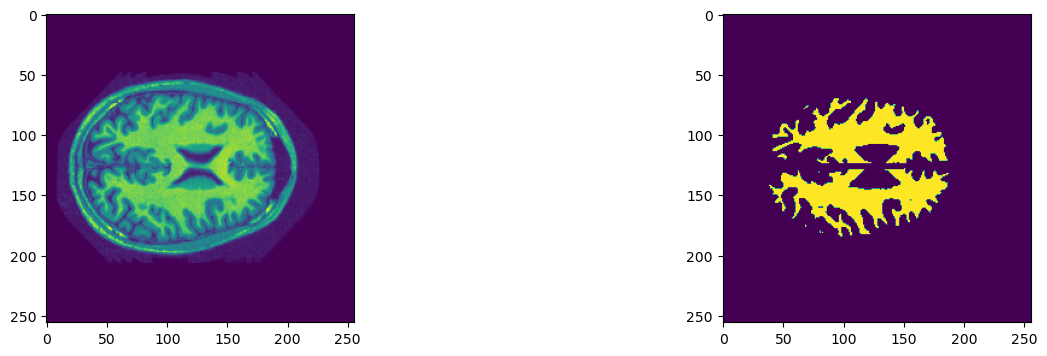

In [6]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,2,figsize=(16,4))
idx=80
axis[0].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
axis[1].imshow(np.logical_or(datasetTrain[idx]["segm"].squeeze()==41, datasetTrain[idx]["segm"].squeeze()==2))
fig.show 

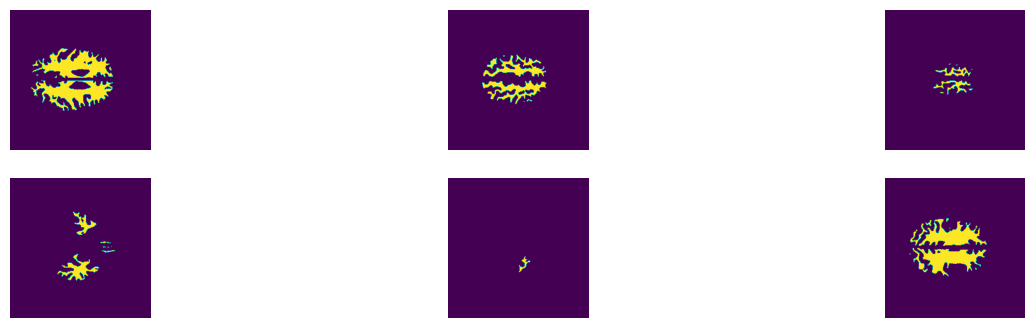

In [7]:
# Get 6 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(6)) 

# Plot: t1n segmentations
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(np.logical_or(datasetTrain[idx]["segm"].squeeze()==41, datasetTrain[idx]["segm"].squeeze()==2))
    axis[i//3,i%3].set_axis_off()
fig.show()

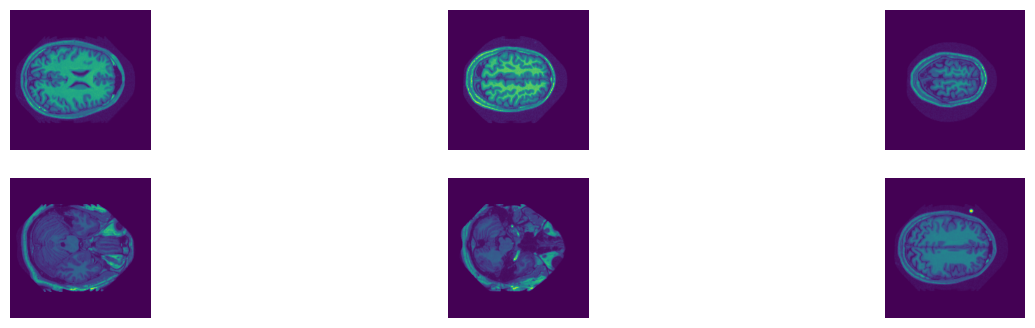

In [8]:
# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

### Playground for random circles

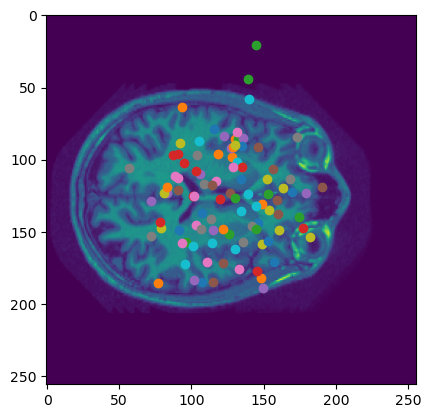

In [9]:
# visualize normal distributions of center points
centers=[]
for _ in np.arange(100):
    centers.append(torch.normal(torch.tensor([127.,127.]),torch.tensor(30.)))

plt.imshow((datasetTrain[70]["gt_image"].squeeze()+1)/2) 
for center in centers:
    plt.scatter(center[0], center[1])

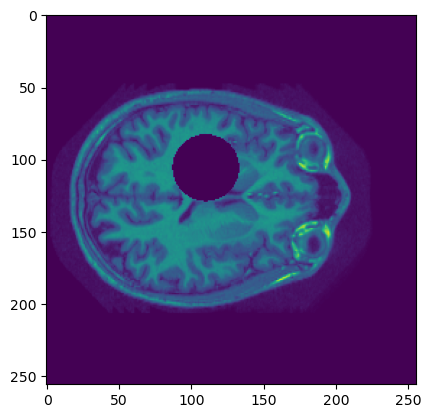

In [10]:
example=torch.zeros((10,256,256)).shape

#create circular mask with random center around the center point of the pictures and a radius between 3 and 40 pixels
center=np.random.normal([127,127],30, size=(example[0],2))
radius=np.random.uniform(low=3,high=40, size=(example[0]))

Y, X = np.ogrid[:256, :256] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
dist_from_center = np.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center

mask = dist_from_center <= radius # creates mask for pixels which are inside the radius
mask = 1-mask

plt.imshow(((datasetTrain[70]["gt_image"].squeeze()+1)/2)*mask[:,:,4]) 



### Prepare Training

In [11]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.unet_img_shape,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [12]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
#sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
#noise = torch.randn(sample_image.shape)
#timesteps = torch.LongTensor([50])
#noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

#tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])


config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [13]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

config.lr_scheduler = "cosine_schedule_with_warmup"

In [14]:
from TrainingConditional import TrainingConditional
from DDIMInpaintPipeline import DDIMInpaintPipeline
from Evaluation2DFilling import Evaluation2DFilling
from Evaluation3DFilling import Evaluation3DFilling  
import PipelineFactories

config.conditional_data = "Circles"

args = {
    "config": config, 
    "model": model, 
    "noise_scheduler": noise_scheduler, 
    "optimizer": optimizer, 
    "lr_scheduler": lr_scheduler, 
    "datasetTrain": datasetTrain, 
    "datasetEvaluation": datasetEvaluation, 
    "dataset3DEvaluation": dataset3DEvaluation, 
    "trainingCircularMasks": True, 
    "evaluation2D": Evaluation2DFilling,
    "evaluation3D": Evaluation3DFilling, 
    "pipelineFactory": PipelineFactories.get_ddim_inpaint_pipeline} 
trainingCircles = TrainingConditional(**args)


2024-05-02 07:42:54.350949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 07:42:54.549878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 07:42:54.549929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 07:42:54.549969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 07:42:54.611316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 07:42:54.615680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

ERROR! Session/line number was not unique in database. History logging moved to new session 62


  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

ssim_full: 0.0005049426108598709
ssim_out: 0.0005082008428871632
ssim_in: -0.0035981438122689724
mse_full: 1.2857580184936523
mse_out: 1.4219989776611328
mse_in: 0.7119406461715698
psnr_full: 4.929007530212402
psnr_out: 4.491606712341309
psnr_in: 7.496161937713623
val_loss: 1.1388198137283325
lpips: 1.2915575504302979
global_step:  1
title:  images
len(image_list):  1
image_list:  [<PIL.Image.Image image mode=L size=256x256 at 0x7F718CC0F310>]


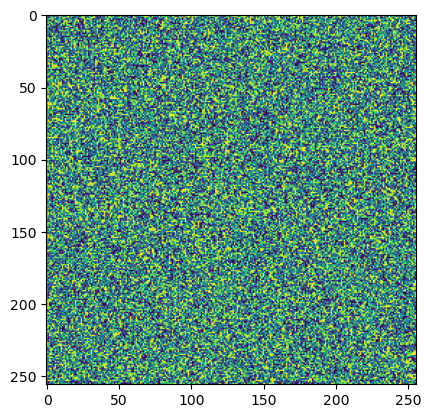

after append images


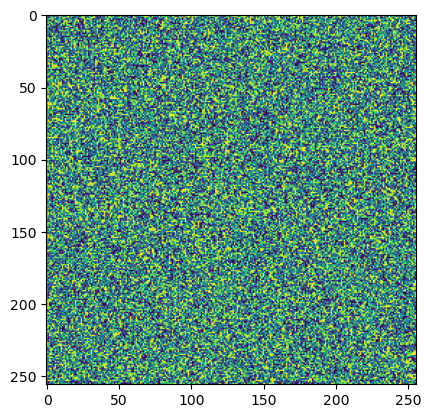

title:  masked_images
len(image_list):  1
image_list:  [<PIL.Image.Image image mode=L size=256x256 at 0x7F71900E0AD0>]


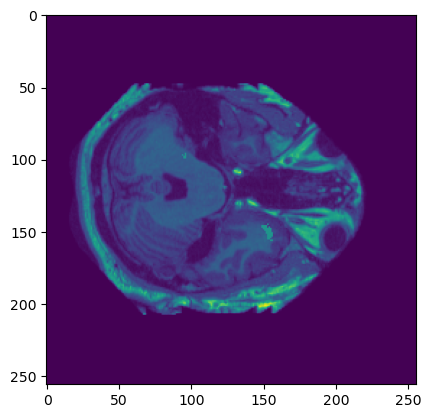

after append images


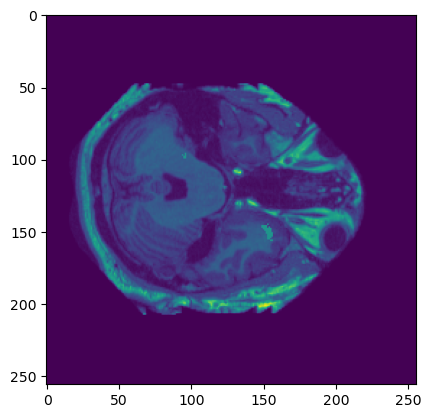

title:  clean_images
len(image_list):  1
image_list:  [<PIL.Image.Image image mode=L size=256x256 at 0x7F720026A950>]


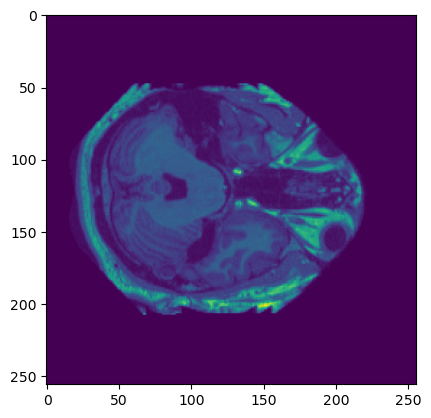

after append images


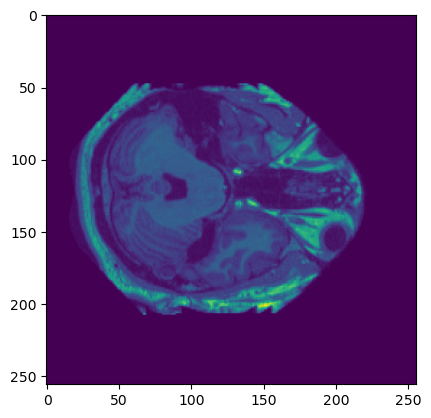

title:  masks
len(image_list):  1
image_list:  [<PIL.Image.Image image mode=L size=256x256 at 0x7F72034F20D0>]


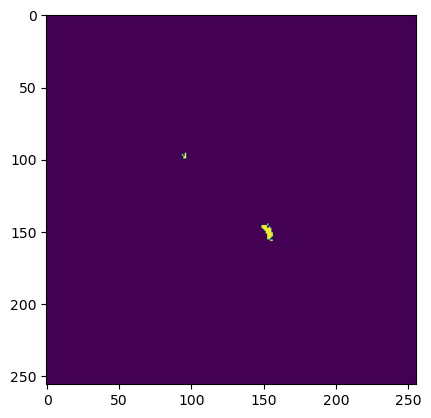

after append images


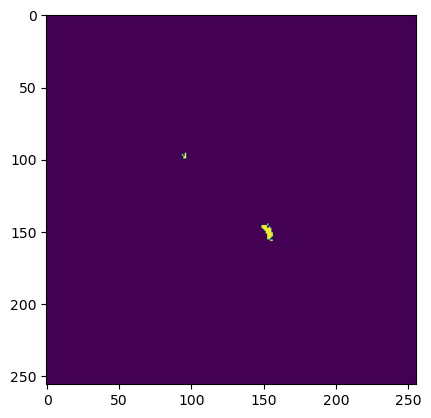

image saved


  0%|          | 0/30 [00:00<?, ?it/s]

Start 3D evaluation


RuntimeError: DataLoader worker (pid 43691) is killed by signal: Killed. 

In [15]:
if config.mode == "train":
    trainingCircles.train()

In [ ]:
if config.mode == "eval":
    pipeline = DDIMInpaintPipeline.from_pretrained(config.output_dir) 
    trainingCircles.evaluate(pipeline)

In [ ]:
print("Finished Training")

In [1]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_circles.ipynb"
filename="lesion_filling_conditioned_circles.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-17: 
            fp.write(line)

[NbConvertApp] Converting notebook lesion_filling_conditioned_circles.ipynb to script
[NbConvertApp] Writing 9391 bytes to lesion_filling_conditioned_circles.py
